# COVID-19 Forecasting - Predictive Data Analysis

After data cleaning and preparation, and exploratory data analysis, it's time to perform predictive data analysis on the dataset.

In order to simplify the prediction process, the dataset have been appropriately converted for each predictive method; some selected variables have been summed up to make predictions for Europe as a whole, rather than analyzing each country separately. The presented approach also leaves some space for analyzing some particular countries separately if desired.


In [245]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import LabelEncoder
from matplotlib.dates import date2num
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
import tensorflow as tf

# Ignore warnings 
import warnings
warnings.filterwarnings('ignore')

In [246]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Helper functions
Some helper functions have been implemented for better readability of the code and evaluation purposes.

In [247]:
# This function calculates mean absolute scaled error

def mean_absolute_scaled_error(y_true, y_pred):
  """
  Implement MASE (assuming no seasonality of data)
  """
  mae = tf.reduce_mean(tf.abs(y_true - y_pred))

  # Find MAE of naive forecast (no seasonality)
  mae_naive = tf.reduce_mean(tf.abs(y_true[1:] - y_true[:-1])) # our seasonality is one day, hence the shift of one

  return mae / mae_naive

In [248]:
# This function evaluates models using different regression metrics

def evaluate_dl_preds(y_true, y_pred):
  """
  Takes in model predictions and truth values and return dictionary of evaluation metrics
  """
  # Make sure you're operating on float32 dtype
  y_true = tf.cast(y_true, dtype = tf.float32)
  y_pred = tf.cast(y_pred, dtype = tf.float32)

  mae = tf.keras.metrics.mean_absolute_error(y_true, y_pred)
  mse = tf.keras.metrics.mean_squared_error(y_true, y_pred)
  rmse = tf.sqrt(mse)
  mape = tf.keras.metrics.mean_absolute_percentage_error(y_true, y_pred)
  mase = mean_absolute_scaled_error(y_true, y_pred)
  r2 = r2_score(y_true, y_pred) # R-squared


  metrics = {"mae": mae.numpy().sum() / len(y_pred),
             "mase": mase.numpy().sum() / len(y_pred),
             "mape": mape.numpy().sum() / len(y_pred),
             "mse": mse.numpy().sum() / len(y_pred),
             "rmse": rmse.numpy().sum() / len(y_pred),
             "r2": r2.sum() / len(y_pred)}

  return metrics

In [249]:
# This function evaluates models using different regression metrics

def evaluate_preds(y_true, y_pred):
  """
  Takes in model predictions and truth values and return dictionary of evaluation metrics
  """
  # Make sure you're operating on float32 dtype
  y_true = tf.cast(y_true, dtype = tf.float32)
  y_pred = tf.cast(y_pred, dtype = tf.float32)

  mae = tf.keras.metrics.mean_absolute_error(y_true, y_pred)
  mse = tf.keras.metrics.mean_squared_error(y_true, y_pred)
  rmse = tf.sqrt(mse)
  mape = tf.keras.metrics.mean_absolute_percentage_error(y_true, y_pred)
  mase = mean_absolute_scaled_error(y_true, y_pred)
  r2 = r2_score(y_true, y_pred) # R-squared


  metrics = {"mae": mae.numpy(),
             "mase": mase.numpy(),
             "mape": mape.numpy(),
             "mse": mse.numpy(),
             "rmse": rmse.numpy(),
             "r2": r2}

  return metrics

In [250]:
# This function normalizes the data using min max scaling

def normalize_series(data, min, max):
    data = data - min
    data = data / max
    return data

In [251]:
# This function is used to map the time series dataset into windows of
# features and respective targets, to prepare it for training and validation.
# The first element of the first window will be the first element of the dataset

def windowed_dataset(series, batch_size, n_past = 10, n_future = 10, shift = 1):
  ds = tf.data.Dataset.from_tensor_slices(series)
  ds = ds.window(size = n_past + n_future, shift = shift, drop_remainder = True)
  ds = ds.flat_map(lambda w: w.batch(n_past + n_future))
  ds = ds.map(lambda w: (w[: n_past], w[n_past :]))
  return ds.batch(batch_size).prefetch(1)

#### Import data

In [252]:
df = pd.read_csv('/content/drive/MyDrive/brunel-term2/CS5812-project/Europe COVID statistics.csv', 
                 header = 0, 
                 parse_dates = ["date"], # parse the date column
                 index_col = ['date']) # tell pandas that column 1 is a datetime
df.head()

,Unnamed: 0,X,country,iso3c,confirmed,deaths,recovered,new.d,new.c,new.r,population,death_rate,recovery_rate,infection_rate,continent
date,,,,,,,,,,,,,,,
2020-01-22,1513,1513,Albania,ALB,0,0,0,0,0,0,2877800,0.0,0.0,0.0,EU
2020-01-23,1514,1514,Albania,ALB,0,0,0,0,0,0,2877800,0.0,0.0,0.0,EU
2020-01-24,1515,1515,Albania,ALB,0,0,0,0,0,0,2877800,0.0,0.0,0.0,EU
2020-01-25,1516,1516,Albania,ALB,0,0,0,0,0,0,2877800,0.0,0.0,0.0,EU
2020-01-26,1517,1517,Albania,ALB,0,0,0,0,0,0,2877800,0.0,0.0,0.0,EU


In [253]:
# Double check for missing values
df.isna().sum()

Unnamed: 0        0
X                 0
country           0
iso3c             0
confirmed         0
deaths            0
recovered         0
new.d             0
new.c             0
new.r             0
population        0
death_rate        0
recovery_rate     0
infection_rate    0
continent         0
dtype: int64

In [254]:
# Drop unnecessary columns 
df = df.drop(columns = {"X", "continent", "Unnamed: 0", "iso3c"}) 

# Show first few rows
df.head()

,country,confirmed,deaths,recovered,new.d,new.c,new.r,population,death_rate,recovery_rate,infection_rate
date,,,,,,,,,,,
2020-01-22,Albania,0,0,0,0,0,0,2877800,0.0,0.0,0.0
2020-01-23,Albania,0,0,0,0,0,0,2877800,0.0,0.0,0.0
2020-01-24,Albania,0,0,0,0,0,0,2877800,0.0,0.0,0.0
2020-01-25,Albania,0,0,0,0,0,0,2877800,0.0,0.0,0.0
2020-01-26,Albania,0,0,0,0,0,0,2877800,0.0,0.0,0.0


In [255]:
df.shape

(25245, 11)

In [256]:
df.columns

Index(['country', 'confirmed', 'deaths', 'recovered', 'new.d', 'new.c',
       'new.r', 'population', 'death_rate', 'recovery_rate', 'infection_rate'],
      dtype='object')

In [257]:
df.dtypes

country            object
confirmed           int64
deaths              int64
recovered           int64
new.d               int64
new.c               int64
new.r               int64
population          int64
death_rate        float64
recovery_rate     float64
infection_rate    float64
dtype: object

In [258]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 25245 entries, 2020-01-22 to 2021-08-04
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   country         25245 non-null  object 
 1   confirmed       25245 non-null  int64  
 2   deaths          25245 non-null  int64  
 3   recovered       25245 non-null  int64  
 4   new.d           25245 non-null  int64  
 5   new.c           25245 non-null  int64  
 6   new.r           25245 non-null  int64  
 7   population      25245 non-null  int64  
 8   death_rate      25245 non-null  float64
 9   recovery_rate   25245 non-null  float64
 10  infection_rate  25245 non-null  float64
dtypes: float64(3), int64(7), object(1)
memory usage: 2.3+ MB


In [259]:
df.describe()

,confirmed,deaths,recovered,new.d,new.c,new.r,population,death_rate,recovery_rate,infection_rate
count,2.524500e+04,25245.000000,2.524500e+04,25245.000000,25245.000000,25245.000000,2.524500e+04,25245.000000,25245.000000,25245.000000
mean,4.191158e+05,10491.489443,2.143770e+05,45.210814,2102.775837,1112.584472,1.661772e+07,0.265331,10.516986,14.838694
std,9.632410e+05,23673.105152,6.279375e+05,125.863878,5656.284670,3538.515947,2.818662e+07,0.548707,34.310814,26.260382
min,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000,0.000000,8.090000e+02,0.000000,0.000000,0.000000
25%,2.268000e+03,48.000000,5.680000e+02,0.000000,9.000000,0.000000,1.886202e+06,0.000000,0.000000,0.452961
50%,4.217700e+04,792.000000,1.259600e+04,3.000000,195.000000,17.000000,5.540718e+06,0.043175,0.514273,4.261016
75%,2.781770e+05,8014.000000,1.290970e+05,22.000000,1179.000000,443.000000,1.070898e+07,0.297474,8.900110,18.374819
max,6.274006e+06,159032.000000,5.609682e+06,1826.000000,117902.000000,70690.000000,1.459345e+08,17.679298,2883.561752,865.265760


In [260]:
country_names = df.country.unique()

country_names, len(country_names)

(array(['Albania', 'Andorra', 'Austria', 'Belgium', 'Bulgaria',
        'Bosnia and Herzegovina', 'Belarus', 'Switzerland', 'Cyprus',
        'Czechia', 'Germany', 'Denmark', 'Spain', 'Estonia', 'Finland',
        'France', 'United Kingdom', 'Greece', 'Croatia', 'Hungary',
        'Ireland', 'Iceland', 'Italy', 'Liechtenstein', 'Lithuania',
        'Luxembourg', 'Latvia', 'Monaco', 'Moldova', 'North Macedonia',
        'Malta', 'Montenegro', 'Netherlands', 'Norway', 'Poland',
        'Portugal', 'Romania', 'Russia', 'San Marino', 'Serbia',
        'Slovakia', 'Slovenia', 'Sweden', 'Ukraine', 'Holy See'],
       dtype=object),
 45)

### Dataset conversion



In [261]:
# Create a data frame dictionary to store your data frames
df_dict = {elem : pd.DataFrame() for elem in country_names}

for key in df_dict.keys():
    df_dict[key] = df[:][df.country == key]

In [262]:
df_dict.keys() # dictionary with 45 countries (45 dictionaries with 561 rows x 11 columns)

dict_keys(['Albania', 'Andorra', 'Austria', 'Belgium', 'Bulgaria', 'Bosnia and Herzegovina', 'Belarus', 'Switzerland', 'Cyprus', 'Czechia', 'Germany', 'Denmark', 'Spain', 'Estonia', 'Finland', 'France', 'United Kingdom', 'Greece', 'Croatia', 'Hungary', 'Ireland', 'Iceland', 'Italy', 'Liechtenstein', 'Lithuania', 'Luxembourg', 'Latvia', 'Monaco', 'Moldova', 'North Macedonia', 'Malta', 'Montenegro', 'Netherlands', 'Norway', 'Poland', 'Portugal', 'Romania', 'Russia', 'San Marino', 'Serbia', 'Slovakia', 'Slovenia', 'Sweden', 'Ukraine', 'Holy See'])

In [263]:
countries = list(df_dict)

# Convert dictionaries to DataFrame format
for country in countries:
  df_dict[country] = pd.DataFrame(df_dict[country])

In [264]:
# Access a country from the dictionary
df_dict['Albania']['new.d'].info()

<class 'pandas.core.series.Series'>
DatetimeIndex: 561 entries, 2020-01-22 to 2021-08-04
Series name: new.d
Non-Null Count  Dtype
--------------  -----
561 non-null    int64
dtypes: int64(1)
memory usage: 8.8 KB


In [265]:
df_dict['Albania']

,country,confirmed,deaths,recovered,new.d,new.c,new.r,population,death_rate,recovery_rate,infection_rate
date,,,,,,,,,,,
2020-01-22,Albania,0,0,0,0,0,0,2877800,0.0,0.000000,0.000000
2020-01-23,Albania,0,0,0,0,0,0,2877800,0.0,0.000000,0.000000
2020-01-24,Albania,0,0,0,0,0,0,2877800,0.0,0.000000,0.000000
2020-01-25,Albania,0,0,0,0,0,0,2877800,0.0,0.000000,0.000000
2020-01-26,Albania,0,0,0,0,0,0,2877800,0.0,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...
2021-07-31,Albania,133081,2457,130222,0,45,17,2877800,0.0,0.590729,1.563694
2021-08-01,Albania,133121,2457,130243,0,40,21,2877800,0.0,0.729724,1.389951
2021-08-02,Albania,133146,2457,130256,0,25,13,2877800,0.0,0.451734,0.868719


## Machine Learning Method: Polynomial Regression

In order to perform prediction using machine learning method, I have used **polynomial regression**, which is a form of a linear regression and a special case of multiple linear regression. 

Polynomial regression is a reasonably simple method that tries to estimate the relationship between the independent and dependent variables as an nth degree polynomial. 

The con of this method is that it is highly sensitive to the outliers, however, it has been checked during data cleaning and preparation that no outliers are present in out dataset, hence this method was possible to use. The dataset have been split into training and testing set with an 80/20 split, and scaled 
by using `fit_transform()` function so that it could be eligible for fitting the polynomial regression model. 

While fitting the model I have tried different configurations, that is using different variables as predictors, and trying different polynomial degree values for fitting the data. 

Furthermore, since it has been noticed during performing Exploratory Data Analysis that the variable `new.d` has higher correlation values with `new.c` and `new.r`, they have been used as predictors in the model.

### Data preparation

In [266]:
ml_df = pd.DataFrame()
ml_df.index = df_dict['Italy']['new.d'].index
ml_df['new.d'] = df_dict['Italy']['new.d'].values

In [267]:
ml_df['new.d'] = 0
ml_df['new.d'].astype(np.int64)
ml_df['new.d'].describe()

count    561.0
mean       0.0
std        0.0
min        0.0
25%        0.0
50%        0.0
75%        0.0
max        0.0
Name: new.d, dtype: float64

In [268]:
ml_df['new.c'] = 0
ml_df['new.c'].astype(np.int64)
ml_df['new.c'].describe()

count    561.0
mean       0.0
std        0.0
min        0.0
25%        0.0
50%        0.0
75%        0.0
max        0.0
Name: new.c, dtype: float64

In [269]:
ml_df['new.r'] = 0
ml_df['new.r'].astype(np.int64)
ml_df['new.r'].describe()

count    561.0
mean       0.0
std        0.0
min        0.0
25%        0.0
50%        0.0
75%        0.0
max        0.0
Name: new.r, dtype: float64

In [270]:
# Sum up daily deaths from all the countries
for country in countries:
  ml_df['new.d'] += df_dict[country]['new.d']
  ml_df['new.c'] += df_dict[country]['new.c']
  ml_df['new.r'] += df_dict[country]['new.r']

In [271]:
ml_df.tail(20)

,new.d,new.c,new.r
date,,,
2021-07-16,1002,151468,30762
2021-07-17,925,120298,31020
2021-07-18,857,110754,24196
2021-07-19,876,157303,25936
2021-07-20,1077,145270,33016
2021-07-21,1045,149599,33441
2021-07-22,1075,148843,32882
2021-07-23,1031,140275,32149
2021-07-24,1030,108622,32834


In [272]:
# Get the data for the model

X = ml_df.iloc[:, 1:3] # variables that are correlated the most with new.d
y = ml_df.iloc[:, 0]

X.shape, y.shape

((561, 2), (561,))

In [273]:
# Split the data into training and testing set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, shuffle = False)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((448, 2), (113, 2), (448,), (113,))

### Apply Polynomial Regression model to the data


In [274]:
# Apply polynomial regression model
poly = PolynomialFeatures(degree = 2)

# Transform the data
X_poly_train = poly.fit_transform(X_train)
X_poly_test = poly.fit_transform(X_test)

# Fit the model
poly.fit(X_poly_train, y_train)
ml_model = LinearRegression()

ml_model.fit(X_poly_train, y_train)

LinearRegression()

In [275]:
# Creating a data frame of test predictions vs actuals
poly_pred = ml_model.predict(X_poly_test)
ml_test_results = pd.DataFrame(data ={'Test Predictions': poly_pred, 'Actuals': y_test})
ml_test_results

,Test Predictions,Actuals
date,,
2021-04-14,4410.108356,4293
2021-04-15,3762.751569,3840
2021-04-16,4205.071138,3754
2021-04-17,4210.361311,2987
2021-04-18,3060.124755,2163
...,...,...
2021-07-31,1745.809305,1027
2021-08-01,1531.987991,936
2021-08-02,1544.578996,1128


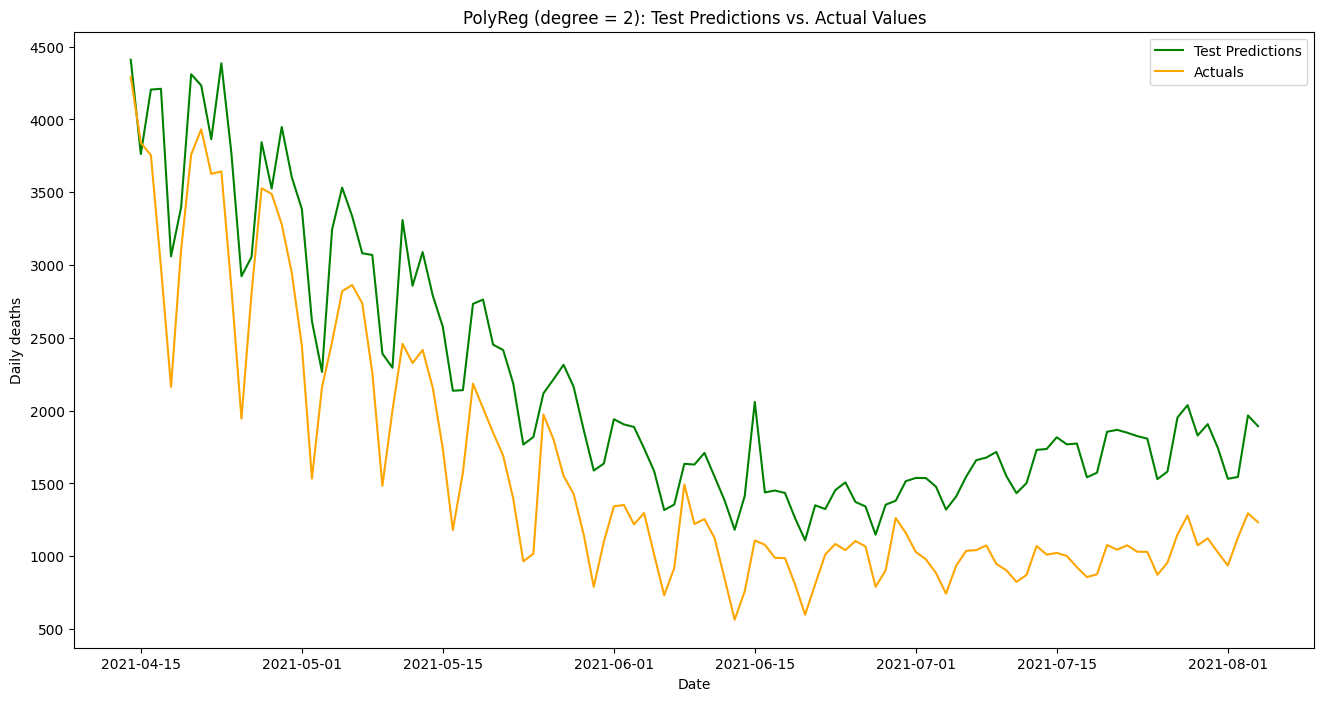

In [276]:
# Plot test predictions
plt.subplots(figsize = (16, 8))
plt.plot(ml_test_results['Test Predictions'], color = "green")
plt.plot(ml_test_results['Actuals'], color = "orange")
plt.title("PolyReg (degree = 2): Test Predictions vs. Actual Values")
plt.xlabel("Date")
plt.ylabel("Daily deaths")
plt.legend(ml_test_results)
plt.savefig('polyreg2_test_predictions_vs_actuals')

In [277]:
polyreg_results = evaluate_preds(y_true = y_test, 
                                 y_pred = poly_pred)
print("Polynomial Regression (deg = 2)\n")
polyreg_results

Polynomial Regression (deg = 2)



{'mae': 591.1533,
 'mase': 2.3718984,
 'mape': 47.860332,
 'mse': 400621.34,
 'rmse': 632.94653,
 'r2': 0.5002806136985023}

In [278]:
# Apply polynomial regression model
poly3 = PolynomialFeatures(degree = 3)

# Transform the data
X_poly3_train = poly3.fit_transform(X_train)
X_poly3_test = poly3.fit_transform(X_test)

# Fit the model
poly3.fit(X_poly_train, y_train)
ml_model = LinearRegression()

ml_model.fit(X_poly3_train, y_train)

LinearRegression()

In [279]:
# Creating a data frame of test predictions vs actuals
poly3_pred = ml_model.predict(X_poly3_test)
ml_test_results = pd.DataFrame(data ={'Test Predictions': poly3_pred, 
                                      'Actuals': y_test})
ml_test_results

,Test Predictions,Actuals
date,,
2021-04-14,4236.608354,4293
2021-04-15,3539.847284,3840
2021-04-16,4087.515250,3754
2021-04-17,4119.410341,2987
2021-04-18,3228.996558,2163
...,...,...
2021-07-31,2024.633687,1027
2021-08-01,1832.118049,936
2021-08-02,1490.212074,1128


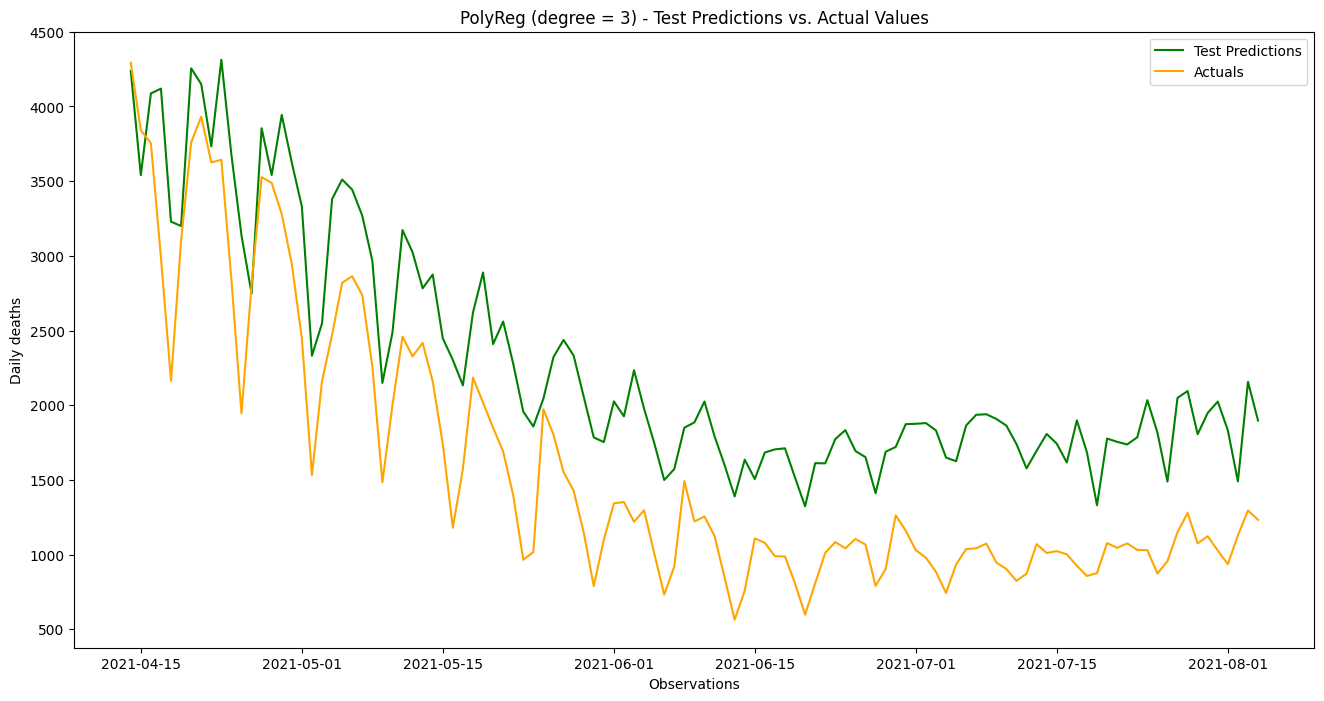

In [280]:
# Plot test predictions
plt.subplots(figsize=(16,8))
plt.plot(ml_test_results['Test Predictions'], color = "green")
plt.plot(ml_test_results['Actuals'], color = "orange")
plt.title("PolyReg (degree = 3) - Test Predictions vs. Actual Values")
plt.xlabel("Observations")
plt.ylabel("Daily deaths")
plt.legend(ml_test_results)
plt.savefig('polyreg3_test_predictions_vs_actuals.png')

In [281]:
polyreg3_results = evaluate_preds(y_true = y_test, 
                                 y_pred = poly3_pred)
print("Polynomial Regression (deg = 3)\n")
polyreg3_results

Polynomial Regression (deg = 3)



{'mae': 694.85,
 'mase': 2.787963,
 'mape': 58.756447,
 'mse': 539563.9,
 'rmse': 734.5501,
 'r2': 0.3269691454575734}

## Deep Learning Method: Long-Short Term Memory Network

In [282]:
# Create a new dataframe for univariate time series analysis
euro_newd = pd.DataFrame()
euro_newd.index = df_dict['Italy']['new.d'].index
euro_newd['new.d'] = df_dict['Italy']['new.d'].values

In [283]:
euro_newd['new.d'] = 0
euro_newd['new.d'].astype(np.int64)
euro_newd['new.d'].describe()

count    561.0
mean       0.0
std        0.0
min        0.0
25%        0.0
50%        0.0
75%        0.0
max        0.0
Name: new.d, dtype: float64

In [284]:
# Sum up daily deaths from all the countries
for country in countries:
  euro_newd['new.d'] += df_dict[country]['new.d']

In [285]:
euro_newd.describe()

,new.d
count,561.000000
mean,2034.486631
std,1827.030665
min,0.000000
25%,441.000000
50%,1263.000000
75%,3312.000000
max,7554.000000


In [286]:
euro_newd

,new.d
date,
2020-01-22,0
2020-01-23,0
2020-01-24,0
2020-01-25,0
2020-01-26,0
...,...
2021-07-31,1027
2021-08-01,936
2021-08-02,1128


Show the new daily deaths cases:


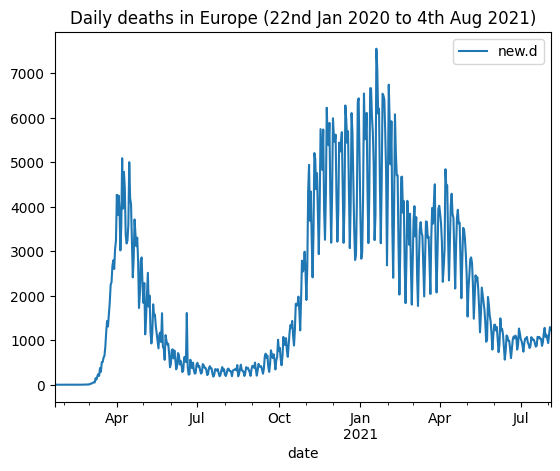

In [287]:
euro_newd.plot()
plt.title("Daily deaths in Europe (22nd Jan 2020 to 4th Aug 2021)")
plt.savefig('daily_deaths_in_europe.png')

In [288]:
data = euro_newd.values
data.dtype

dtype('int64')

### Data normalization
Normalization is a process of rescaling the data from the original range so that all values are within the range of 0 and 1. Since neural networks tend to train better and faster on rescaled data, and it is possible in this case to estimate the minimum and maximum values in the available data, the daily deaths variable `new.d` has been normalized. 

In [289]:
data = normalize_series(data, data.min(axis = 0), data.max(axis = 0))

In [290]:
data.min(), data.max()

(0.0, 1.0)

### Split the data into train and test set

In [291]:
SPLIT_TIME = int(len(data) * 0.8)
x_train = data[: SPLIT_TIME]
x_valid = data[SPLIT_TIME :]

In [292]:
BATCH_SIZE = 32
N_PAST = 10
N_FUTURE = 10
SHIFT = 1

In [293]:
# Code to create windowed train and validation datasets.
train_set = windowed_dataset(series = x_train, 
                             batch_size = BATCH_SIZE,
                             n_past = N_PAST, 
                             n_future = N_FUTURE,
                             shift = SHIFT)

valid_set = windowed_dataset(series = x_valid, 
                             batch_size = BATCH_SIZE,
                             n_past = N_PAST, 
                             n_future = N_FUTURE,
                             shift = SHIFT)

In [294]:
train_set, valid_set

(<_PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 1), dtype=tf.float64, name=None), TensorSpec(shape=(None, None, 1), dtype=tf.float64, name=None))>,
 <_PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 1), dtype=tf.float64, name=None), TensorSpec(shape=(None, None, 1), dtype=tf.float64, name=None))>)

### Create a LSTM model

In [295]:
def create_model():

  model = tf.keras.Sequential([
      tf.keras.layers.LSTM(64, input_shape = [None, 1]),
      tf.keras.layers.Dense(8, activation = 'relu'),
      tf.keras.layers.Dense(1)
  ])

  model.compile(loss = 'mean_absolute_error', 
                 optimizer = tf.keras.optimizers.Adam(learning_rate=0.001), 
                 metrics =['mae', 'mse']) 
  return model

def fit_model(model, train_set, valid_set):
  # Specify training callbacks
  checkpoint_cb = tf.keras.callbacks.ModelCheckpoint('lstm_model/', save_best_only = True) # save only the best model (one with the lowest validation loss)
  # Fit the model
  history = model.fit(train_set, 
                      epochs = 100, 
                      validation_data = valid_set, 
                      callbacks = [checkpoint_cb])
  
  return history

In [296]:
lstm_model = create_model()

In [297]:
history = fit_model(lstm_model, train_set, valid_set)

Epoch 1/100
      8/Unknown - 3s 7ms/step - loss: 0.1053 - mae: 0.1053 - mse: 0.0335   

14/14 [==============================] - 9s 492ms/step - loss: 0.2198 - mae: 0.2198 - mse: 0.0953 - val_loss: 0.0446 - val_mae: 0.0446 - val_mse: 0.0033
Epoch 2/100
14/14 [==============================] - 0s 11ms/step - loss: 0.1315 - mae: 0.1315 - mse: 0.0240 - val_loss: 0.1145 - val_mae: 0.1145 - val_mse: 0.0148
Epoch 3/100
 8/14 [================>.............] - ETA: 0s - loss: 0.1192 - mae: 0.1192 - mse: 0.0170

14/14 [==============================] - 4s 335ms/step - loss: 0.1244 - mae: 0.1244 - mse: 0.0207 - val_loss: 0.0428 - val_mae: 0.0428 - val_mse: 0.0034
Epoch 4/100
 8/14 [================>.............] - ETA: 0s - loss: 0.0591 - mae: 0.0591 - mse: 0.0074

14/14 [==============================] - 4s 339ms/step - loss: 0.0934 - mae: 0.0934 - mse: 0.0167 - val_loss: 0.0378 - val_mae: 0.0378 - val_mse: 0.0026
Epoch 5/100
14/14 [==============================] - ETA: 0s - loss: 0.0877 - mae: 0.0877 - mse: 0.0179

14/14 [==============================] - 5s 381ms/step - loss: 0.0877 - mae: 0.0877 - mse: 0.0179 - val_loss: 0.0374 - val_mae: 0.0374 - val_mse: 0.0032
Epoch 6/100
 9/14 [==================>...........] - ETA: 0s - loss: 0.0653 - mae: 0.0653 - mse: 0.0120    

14/14 [==============================] - 4s 311ms/step - loss: 0.0934 - mae: 0.0934 - mse: 0.0192 - val_loss: 0.0315 - val_mae: 0.0315 - val_mse: 0.0021
Epoch 7/100
14/14 [==============================] - 0s 17ms/step - loss: 0.0855 - mae: 0.0855 - mse: 0.0156 - val_loss: 0.0375 - val_mae: 0.0375 - val_mse: 0.0030
Epoch 8/100
14/14 [==============================] - 0s 20ms/step - loss: 0.0853 - mae: 0.0853 - mse: 0.0157 - val_loss: 0.0374 - val_mae: 0.0374 - val_mse: 0.0032
Epoch 9/100
14/14 [==============================] - 0s 21ms/step - loss: 0.0862 - mae: 0.0862 - mse: 0.0152 - val_loss: 0.0347 - val_mae: 0.0347 - val_mse: 0.0026
Epoch 10/100
14/14 [==============================] - 0s 19ms/step - loss: 0.0828 - mae: 0.0828 - mse: 0.0151 - val_loss: 0.0383 - val_mae: 0.0383 - val_mse: 0.0034
Epoch 11/100
14/14 [==============================] - 0s 19ms/step - loss: 0.0855 - mae: 0.0855 - mse: 0.0155 - val_loss: 0.0342 - val_mae: 0.0342 - val_mse: 0.0026
Epoch 12/100
14/14 [=====

In [298]:
# Load the best performing model
lstm_model = tf.keras.models.load_model('lstm_model/')

### Save a model

In [299]:
lstm_model.save('lstm_model/lstm_model.h5')

### LSTM Model Evaluation

In [300]:
# Creating a data frame of test predictions vs actuals
lstm_test_pred = lstm_model.predict(valid_set)

3/3 [==============================] - 0s 14ms/step


In [301]:
# This function evaluates the model

def model_forecast(model, series, window_size, batch_size):
  ds = tf.data.Dataset.from_tensor_slices(series)
  ds = ds.window(window_size, shift = 1, drop_remainder = True)
  ds = ds.flat_map(lambda w: w.batch(window_size))
  ds = ds.batch(batch_size, drop_remainder = True).prefetch(1)
  forecast = model.predict(ds)

  return forecast

In [302]:
rnn_forecast = model_forecast(lstm_model, normalize_series(data, min(data), max(data)), N_PAST, BATCH_SIZE)
rnn_forecast = rnn_forecast[SPLIT_TIME - N_PAST:-1, 0]

x_valid = np.squeeze(x_valid[:rnn_forecast.shape[0]])
result = tf.keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()

17/17 [==============================] - 0s 6ms/step


In [303]:
lstm_results = evaluate_preds(y_true = x_valid,
                                 y_pred = rnn_forecast)

lstm_results

{'mae': 0.036307342,
 'mase': 1.0593734,
 'mape': 17.840784,
 'mse': 0.0025534362,
 'rmse': 0.050531536,
 'r2': 0.8275286448325453}

In [304]:
lstm_results_df = pd.DataFrame({'Test Predictions': rnn_forecast, 
                                   'Actuals': x_valid})

lstm_results_df

,Test Predictions,Actuals
0,0.422763,0.568308
1,0.435904,0.508340
2,0.444865,0.496955
3,0.449620,0.395420
4,0.436912,0.286338
...,...,...
100,0.123076,0.136484
101,0.123684,0.136352
102,0.124611,0.115568
103,0.124147,0.126555


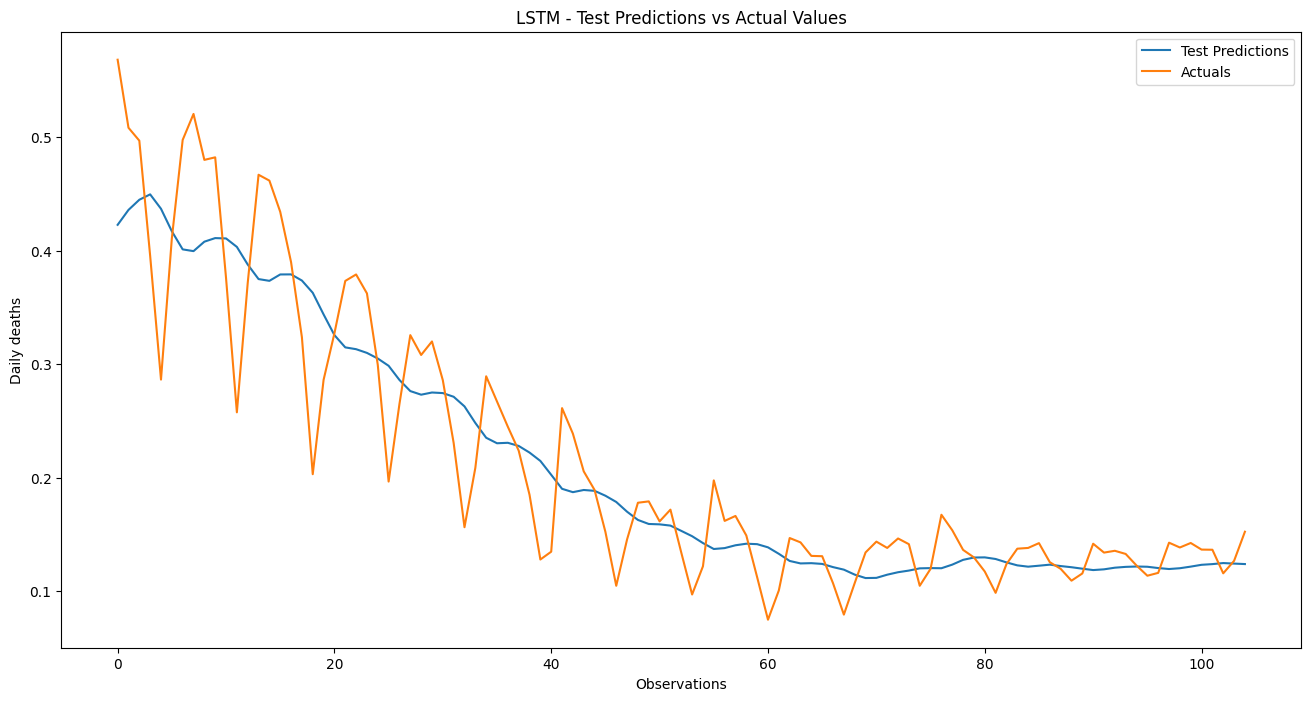

In [305]:
# Plot train predictions vs actuals - first 1000 observations for closer fit investigation
plt.subplots(figsize = (16, 8))
plt.plot(lstm_results_df['Test Predictions'])
plt.plot(lstm_results_df['Actuals'])
plt.title("LSTM - Test Predictions vs Actual Values")
plt.xlabel("Observations")
plt.ylabel("Daily deaths")
plt.legend(lstm_results_df)
plt.savefig('lstm_test_preds_vs_actuals.png')